# Evaluation of Kalman filtering for linear and logistic regression
# Part II: full rank filters for linear regression

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction

In this tutorial we show how to use the Kalman filter for large scale regression and binary classification problems. 

In this part, we review classical stochastic optimization approach for linear regression and then we show how the full rank linear Kalman filter is equivalent to the online Newton algorithm. 

# Stochastic optimization 

Suppose we have a dataset $(u_i,y_i)_{i=1,..,N}$, a learning model parametrized by $x$ (supposed linear in our work) and a loss function $L$ on this dataset which can be splitted in "one sample losses" $l_i$: 

\begin{align}
L(x)=\sum_{i=1}^N l_i(x),
\end{align}

where $l_i$ depends on $x$ but also on $u_i$ and $y_i$. When the datas are availables one by one or when the amount of datas is intractable in batch,  we are interest to compute the optimal $x$ in an online way, ie step by step. In this case we define the partial loss function up to observation $t<N$ by :

\begin{align}
L_t(x)=\sum_{i=1}^{t\leq N} l_i(x).
\end{align}

The classical way to minimize this loss in an oline way  is to use stochastic optimization algorithms: 

\begin{align}
& \textbf{Stochastic optimization}\\
x_{t}&=x_{t-1}-P_{t-1}\nabla l_i(x_{t-1}),\\
&
\end{align}

where $\nabla l_i$ is the gradient of the one sample loss with respect to $x$ and $P_{t-1}$ is a matrix which can be used to reweight the coordinates of the gradient in function of the local curvature. In an online Newton algorithm this matrix is the inverse of the Hessian around $x_{t-1}$: $P_{t-1}=\nabla^2L_t(x_{t-1})^{-1}$. In stochastic gradient the step is the same in all the descent directions $P_{t-1}=\gamma_t \mathbf{I}$. Since the Hessian is hard to compute in high dimension, some algorithms try to approximate it as Gauss-Newton which consider the outer product approximation $P_{t-1} = \sum_{i=1}^t \nabla l_i(x_{t-1})\times \nabla l_i(x_{t-1})$ or Adagard which keep only the diagonal (square root) of the outer product : $P_{t-1} = \mathrm{Diag}\left(\sum_{i=1}^t \nabla l_i(x_{t-1})\times \nabla l_i(x_{t-1})\right)^{-\frac{1}{2}}$.

Let us test them for our least mean square loss:

In [2]:
import random
import numpy as np
import math
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [3]:
def grad_li(ui,yi,x):
    return ui*(x.T.dot(ui)-yi)

def hessian_li(ui,yi,x):
    return np.outer(ui,ui)

def stochasticGradient(x0,U,Y,grad_li,gradStep=1,passNumber=1,typeOptim='stochastic',sigma0=1e6,normalizeInputs=False,seed=1):
    
    N, d=U.shape
    P=np.empty([d,d])
    
    if normalizeInputs: #mean supposed already null
        stdU=np.std(U,axis=0)
        U=U/stdU
        x0=x0.reshape(d,)*stdU
        x0=x0.reshape(d,1)
        
    x=x0

    epsilon=1e-8
    if typeOptim=='adagrad':
        sum_gt2 = np.ones([d,1])/sigma0**2
        P=np.identity(d)*sigma0**2*gradStep
    if typeOptim=='gauss-newton':
        hessian = np.identity(d)/sigma0**2
        P=np.identity(d)*sigma0**2*gradStep
    if typeOptim=='stochastic':
        P=np.identity(d)*gradStep
            
    # we stock intermediate results in array where 
    # number of rows match number of observations
    history_x = np.zeros((N*passNumber+1,d))
    history_x[0,:]=x0.flatten()
    history_P = np.zeros((N*passNumber+1,d*d))
    history_P[0,:]=P.flatten()
    t=1
    for numeroPass in range(1,passNumber+1):   
        for i in range(0,N):
            yi=Y[i].reshape(1,)
            ui=U[i].reshape(d,1)
            
            # compute the gradient
            gt=grad_li(ui,yi,x)
            if typeOptim=='stochastic':
                gradient=gt/(t+1)
                P=np.identity(d)*gradStep/(t+1)
                history_P[t,:]=P.flatten()
            if typeOptim=='stochastic-sqrt':
                gradient=gt/math.sqrt(t+1)
                P=np.identity(d)*gradStep/math.sqrt(t+1)
                history_P[t,:]=P.flatten()
            if typeOptim=='stochastic-const':
                gradient=gt
                P=np.identity(d)*gradStep
                history_P[t,:]=P.flatten()
            if typeOptim=='adagrad':
                sum_gt2=sum_gt2+gt*gt
                w=np.sqrt(sum_gt2)
                gradient=gt/w
                P=np.diag(gradStep/w)
                history_P[t,:]=P.flatten()
            if typeOptim=='gauss-newton':
                hessian=hessian+np.outer(gt,gt)
                gradient=LA.inv(hessian).dot(gt)
                P=LA.inv(hessian)*gradStep
                history_P[t,:]=P.flatten()
            x=x-gradStep*gradient
            history_x[t,:]=x.flatten()
            t=t+1
            
        if numeroPass>1:
            # To manage different pass, shuffle the dataset
            DataSet=list(zip(U,Y))
            random.seed(seed)
            random.shuffle(DataSet)
            inputs,outputs = zip(*DataSet)
    
    if normalizeInputs:
        x=x/stdU
        history_x=history_x/stdU
    return x, P, history_x, history_P

def onlineNewton(x0,Hessian0,U,Y,grad_li,hess_li,passNumber=1,seed=1):
    
    N, d=U.shape
    x=x0 
    hessian=Hessian0
    P=LA.inv(hessian)
            
    # we stock intermediate results in array where 
    # number of rows match number of observations
    history_x = np.zeros((N*passNumber+1,d))
    history_x[0,:]=x0.flatten()
    history_P = np.zeros((N*passNumber+1,d*d))
    history_P[0,:]=P.flatten()
    t=1
    for numeroPass in range(1,passNumber+1):   
        for i in range(0,N):
            yi=Y[i].reshape(1,)
            ui=U[i].reshape(d,1)
        
            # compute the gradient
            gradient=grad_li(ui,yi,x)
            hessian=hessian+hess_li(ui,yi,x)
            x=x-LA.inv(hessian).dot(gradient)
            history_x[t,:]=x.flatten()
            t=t+1
            
        if numeroPass>1:
            # To manage different pass, shuffle the dataset
            DataSet=list(zip(U,Y))
            random.seed(seed)
            random.shuffle(DataSet)
            inputs,outputs = zip(*DataSet)
        
    return x,P,history_x,history_P

Let us test this optimization algorithms on the least mean square problem for a simple 2D dataset of $\textbf{isotropic}$ covariance:

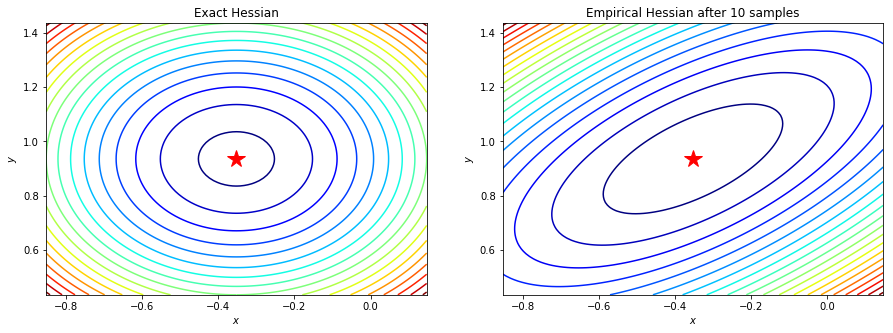

In [8]:
from LargeScaleKalmanLibrary.DataGenerator import LMS_data_generator
from LargeScaleKalmanLibrary.Evaluation import LMSLoss,plotLMSShape,plotLMSLoss

Nsamples=100
d=2
c=1
sigmaLabel=1
sigmaInput=1
seedXP=1
Y,U,x_opt,Cov_u=LMS_data_generator(Nsamples,d,c,sigmaLabel,sigmaInput,seed=seedXP,covarianceInputs='isotropic')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
plotLMSShape(ax1,x_opt,Cov_u,nbcontours=20)
ax1.set_title('Exact Hessian')
Us=U[0:10]
plotLMSShape(ax2,x_opt,Us.T.dot(Us)/10,nbcontours=20)
ax2.set_title('Empirical Hessian after 10 samples')
plt.show()

Even if the theoretical Hessian is isotropic, the empirical Hessian can have non isotropic shape and SGD can benefit from normalization.

We compute the solution (with only one pass on datas):

In [9]:
x0=x_opt+2
x0=x0.reshape(d,1)
numberPass=2

Hessian0=np.identity(d)*1e-12 
x_on,P,history_x_on,history_P = onlineNewton(x0,Hessian0,U,Y,grad_li,hessian_li,numberPass)
stepSGD=1
x_sgd,P,history_x_sgd,history_P = stochasticGradient(x0,U,Y,grad_li,stepSGD,numberPass,\
                                         typeOptim='stochastic-sqrt')

stepADAGRAD=1
x_ada,P,history_x_ada,history_P = stochasticGradient(x0,U,Y,grad_li,stepADAGRAD,numberPass,\
                                         typeOptim='adagrad')

We now recompute the solution with normalization on datas before to assess the difference. To normalize the datas without change the final optimal, we process as follow:

- compute the standard deviation vector $std_u$ of inputs (we suppose the mean of inputs is already 0)
- normalize inputs : $U^n=U/std_u$
- modify the initial guess : $x_0^n=x_0.std_u$
- run the algorithm
- modify the output results: $\hat{x}=\hat{x}^n/std_u$

In [10]:
#normalization 
stdU=np.std(U,axis=0)
Un=U/stdU
print('the loss with x=x_opt is',LMSLoss(Y,U,x_opt))
print('the loss with x=x_opt is',LMSLoss(Y,Un,x_opt*stdU))
x0n=x0.reshape(d,)*stdU
x0n=x0n.reshape(d,1)

x_on2,P,history_x_on2,history_P = onlineNewton(x0n,Hessian0,Un,Y,grad_li,hessian_li,numberPass)
x_on2=x_on2/stdU
history_x_on2=history_x_on2/stdU

stepSGD=1
x_sgd2,P,history_x_sgd2,history_P = stochasticGradient(x0n,Un,Y,grad_li,stepSGD,numberPass,\
                                         typeOptim='stochastic')
x_sgd2=x_sgd2/stdU
history_x_sgd2=history_x_sgd2/stdU

stepADAGRAD=1
x_ada2,P,history_x_ada2,history_P = stochasticGradient(x0n,Un,Y,grad_li,stepADAGRAD,numberPass,\
                                         typeOptim='adagrad')
x_ada2=x_ada2/stdU
history_x_ada2=history_x_ada2/stdU

the loss with x=x_opt is 0.393585902425
the loss with x=x_opt is 0.393585902425


And we plot how the loss is decreasing : 

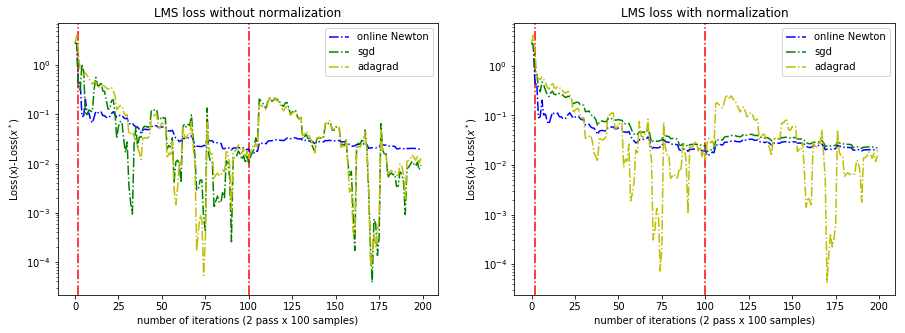

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharex=True)
plotLMSLoss(ax1,U,Y,x_opt,numberPass,[history_x_on,history_x_sgd,history_x_ada],\
            ['online Newton','sgd','adagrad'],plotOptimal=False,title='LMS loss without normalization')
plotLMSLoss(ax2,U,Y,x_opt,numberPass,[history_x_on2,history_x_sgd2,history_x_ada2],\
            ['online Newton','sgd','adagrad'],plotOptimal=False,title='LMS loss with normalization')
plt.show()

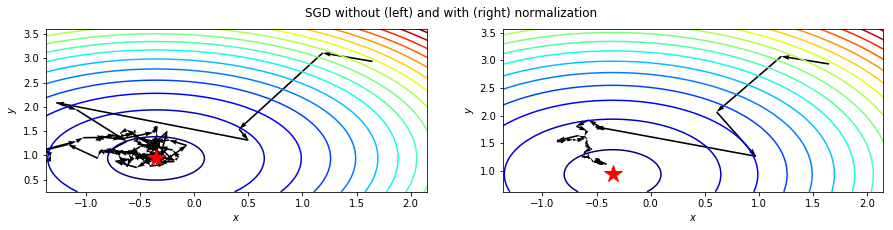

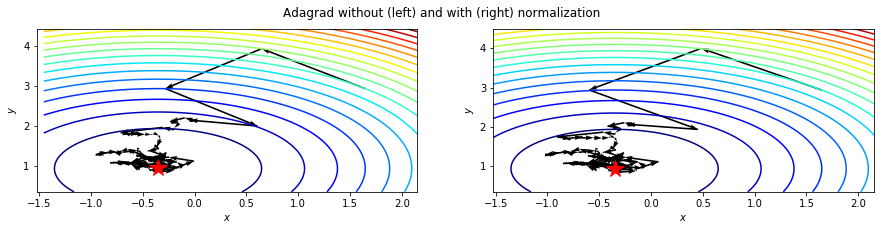

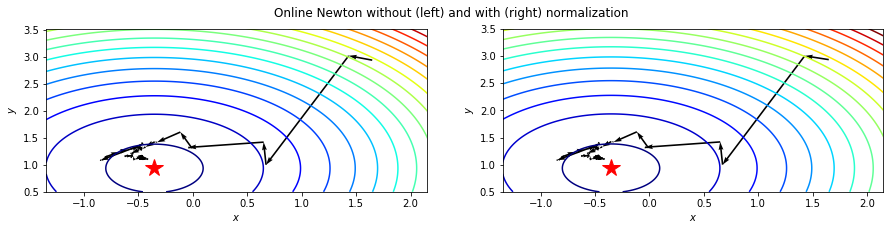

In [12]:
from LargeScaleKalmanLibrary.Evaluation import plotLMSPath


fig,(ax1,ax2)=plt.subplots(1,2,num=1,figsize=(15,3),sharex=True)
plotLMSPath(ax1,history_x_sgd,x_opt,Cov_u)
plotLMSPath(ax2,history_x_sgd2,x_opt,Cov_u)
plt.suptitle('SGD without (left) and with (right) normalization')
fig,(ax1,ax2)=plt.subplots(1,2,num=2,figsize=(15,3),sharex=True)
plotLMSPath(ax1,history_x_ada,x_opt,Cov_u)
plotLMSPath(ax2,history_x_ada2,x_opt,Cov_u)
plt.suptitle('Adagrad without (left) and with (right) normalization')
fig,(ax1,ax2)=plt.subplots(1,2,num=3,figsize=(15,3),sharex=True)
plotLMSPath(ax1,history_x_on,x_opt,Cov_u)
plotLMSPath(ax2,history_x_on2,x_opt,Cov_u)
plt.suptitle('Online Newton without (left) and with (right) normalization')
plt.show()

Online Newton give better results. Adagrad decrease with quite same speed than online Newton but is much less stable.  The normalization process help SGD convergence, have little effect on Adagard and no effect on online Newton.

# The linear Kalman filter 

## From weighted least mean square to online Newton

This part can be skip to go directely to the full Kalman equations but the curious reader will find in this section some fondamental explanation for the Kalman update formula. 

The least mean square problem for a dataset $(u_i,y_i)$ weighted with a noise $\sigma_i$ is:

\begin{align*}
& \underset{x}{Min} \sum_{i=1}^t \frac{1}{2 \sigma_i^2}(y_i - u_i^Tx)^2 + \frac{1}{2}x^TQ_0x, \\
&
\end{align*}

where $Q_0$ is a regularization term. This loss can be rewritten as:

\begin{align*}
& \underset{X}{Min} \frac{1}{2} X^TQ_tX - v_t^TX + C, \\ 
&
\end{align*}

where $v_t$ is the gradient of the loss, C is a term independent of $x$ and $Q_{t}$ is the Hessian matrix of the least mean square loss up to time $t$: 

\begin{align*}
Q_{t}=\sum_{i=1}^{t} \frac{1}{\sigma_i^2} u_iu_i^T + Q_0.\\
&
\end{align*}

The solution of the least square problem is well known and is given by the normal equation : $\hat{x}_t=Q_t^{-1}v_t$. To obtain a recursive equation, we need to express $\hat{x}_t$ in function of $\hat{x}_{t-1}$, the trick is to rearrange terms and use Woodbury formula to let appear the residual error term : $y_t-u_t^Tx$, such that we obtain the Kalman update equations:  

\begin{align*}
&x_{t}=x_{t-1}+K_{t}(y_{t}-u_{t}^Tx_{t-1}) \\
&K_t=Q_{t-1}^{-1}u_{t}(\sigma_t^2 +u_{t}^TQ_{t-1}^{-1}u_{t})^{-1}=\frac{1}{\sigma_t^2}Q_t^{-1}u_{t},\\
&
\end{align*}

which can be rewritten again as a online Newton descent : 

\begin{align*}
x_{t}&=x_{t-1}+K_{t}(y_{t}-u_{t}^Tx_{t-1})=x_{t-1}+\frac{1}{\sigma_t^2}Q_t^{-1}u_{t}(y_{t}-u_{t}^Tx_{t-1})\\
&=x_{t-1}+Q_t^{-1}\nabla l_t(x_{t-1}). \\
&
\end{align*}

The linear Kalman filter is equivalent to the online Newton descent and both are recursive optimal solver for the least mean square problem, nice result ! Let us go further and show how the Hessian $Q_t$ is also link to the uncertainties on state $x_t$: 

If we consider the Bayesian point of view where $x_t$ is supposed a random Gaussian variable:

\begin{align*}
x_t = x/y_1..y_t \sim \mathcal{N}(\bar{x}_t,P_t)\\
&
\end{align*} 

We search to estimate the mean of this variable $\hat{x}_t=\bar{x}_t$ and the covariance matrix $P_t=\mathbb{E}[x_tx_t^T]-\bar{x}_t\bar{x}_t^T$. Using Baye's rule and the conditional probability $y/\hat{x}_{t-1}\sim\mathcal{N}(u_t^T\hat{x}_{t-1},u_t^TP_{t-1}u_t)$, it can be shown that:

\begin{align*}
P_{t}^{-1}=P_{t-1}^{-1} + \frac{1}{\sigma_i^2} u_tu_t^T , 
\end{align*}

which are the fondamental information filter equations. If we compare this equations with the expression of the Hessian matrix $Q_t$, we find directly $P_t=Q_t^{-1}$, the Hessian can be interpreted as the inverse of the covariance matrix of the state, other nice result ! The optimal gain write now: 

\begin{align*}
K_t=P_{t-1}H_{t}^T(C_{t}+H_{t}P_{t-1}H_{t}^T)^{-1},\\
&
\end{align*}

where $H_t=u_t^T$ is called the observation matrix in linear system space theory. The application of the linear Kalman for learning is caracterized by a state highely non observable with an observation matrix $H$ of low rank which depend on time $t$.

## Linear Kalman equations

For the least mean square prolem, the linear Kalman filter (training version) is equivalent to the online Newton descent. The training version of the linear Kalman is a particular linear Kalman where the state is stationary and the observations matrix match the input datas ($H_{t+1}=u^T_{t+1}$ in scalar case):

\begin{align}
& \textbf{Linear Kalman filter} \\
&x_{t}=x_{t-1}+K_{t}(y_{t}-H_{t}x_{t-1}) \\
&K_{t}=P_{t-1}H_{t}^T(R_{t}+H_{t}P_{t-1}H_{t}^T)^{-1} \\
&P_{t}=(\mathbb{I}-K_{t}H_{t})P_{t-1} \\
&P_{t}^{-1}=P_{t-1}^{-1} + H_t^TR_{t}^{-1}H_t , \hspace{1cm} \text{(1)}
&
\end{align}

where the step $t$ correspond to the index of obervations $y_t$, $x_t$ is the hidden parameter learned from the $t$ first observations, $H_t=u_t^T$ is the transpose of the input vector, $R_t=\sigma_t^2$ is the covariance of the noise (supposed known a priori and independent of $t$), $P_t$ is the estimation of the uncertainty on learned parameters (as a covariance matrix) and $K_t$ is the Kalman gain. 

In [13]:
def linearKalmanFilter(x0,P0,R,inputs,outputs,passNumber=1,seed=1):
    """
    linear Kalman Filter (learning version)

    Parameters
    ----------
    x0 : vector (d x 1)
        the initial guess for parameters. 
    P0 : matrix (d x d)
        the initial guess for covariance of parameters. 
    R : matrix (m x m)
        the covariance of noise of outputs (supposed constant).
    inputs : matrix N x md 
        the inputs in a matrix form: each row correspond to a 
        matrix H_t m x d put in vector form
    outputs : matrix N x m
        the outputs in na matrix form: each row correspond to a sample
    passNumber : int
        number of times we read the training datas (one pass by default)
    Returns
    -------
    xt : vector (d x 1)
        the estimated parameter. 
    Pt : matrix (d x d)
        the covariance on estimate.
    history_x : matrix N x d
        the history of all past estimates (results of iterations of algorithm).
    history_P : matrix N x dd
        the history of all past covariance estimates. 
    """
    
    d=x0.shape[0] #dimension of state
    N=outputs.shape[0] #number of samples
    m=outputs.shape[1] #dimension of outputs
    x=x0 
    P=P0
    t=1 # number of iterations
   
    # we stock intermediate results in array where 
    # number of rows match number of observations
    history_x = np.zeros((N*passNumber+1,d))
    history_x[0,:]=x0.flatten()
    history_P = np.zeros((N*passNumber+1,d*d))
    history_P[0,:]=P0.flatten()
    
    for numeroPass in range(1,passNumber+1):   
        for i in range(0,N):   
            
            # prediction error
            y=outputs[i].reshape(m,1)
            H=inputs[i].reshape(m,d)
            err=y-H.dot(x)
        
            # computation of optimal gain
            S=R+H.dot(P).dot(H.T)
            K=P.dot(H.T).dot(LA.inv(S))
        
            # update state and covariance of state
            x=x+K.dot(err)
                
            P=P-K.dot(H).dot(P)
            
            history_x[t,:]=x.flatten()
            history_P[t,:]=P.flatten()
            
            t=t+1
        
        if numeroPass>1:
            # To manage different pass, shuffle the dataset
            DataSet=list(zip(inputs,outputs))
            random.seed(seed)
            random.shuffle(DataSet)
            inputs,outputs = zip(*DataSet)
        
    return x,P,history_x,history_P

## Kalman filter, online newton, adagrad and gauss-newton

We test the linear Kalman filter on the same dataset than for stochastic gradient experiments and compare it to online newton and also to the gauss-newton second order approximation. We can notice the variance of labels have no incidence on filter when the noise is scalar and homoscedastic: 

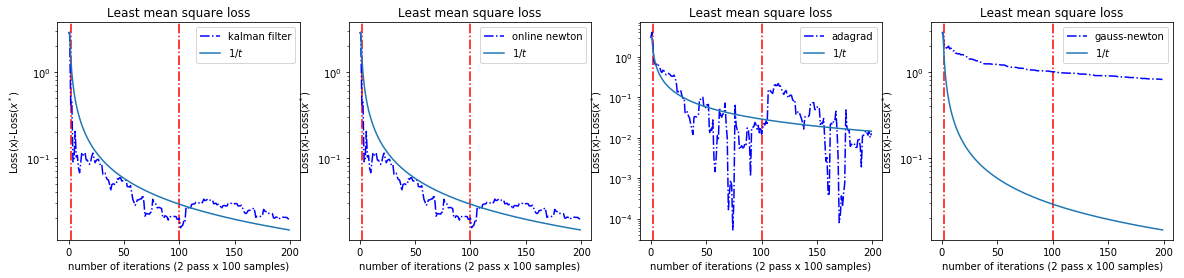

In [14]:
Nsamples=100
d=2
c=1
sigmaLabel=1
sigmaInput=1
seedXP=1
Y,U,x_opt,Cov_u=LMS_data_generator(Nsamples,d,c,sigmaLabel,sigmaInput,seed=seedXP,covarianceInputs='isotropic')
x0=x_opt+2
x0=x0.reshape(d,1)
numberPass=2

sigma0=1e6
Hessian0=np.identity(d)/sigma0**2
P0=LA.inv(Hessian0) #the initial covariance is given by the inverse of the initial Hessian 
R=1 # the variance of labels have no incidence on filter when it is a constant scalar
x_on,P_on,history_x_on,history_P_on = onlineNewton(x0,Hessian0,U,Y,grad_li,hessian_li,numberPass)
x_ka,P_ka,history_x_ka,history_P_ka = linearKalmanFilter(x0,P0,R,U,Y,numberPass)
x_ada,P_ada,history_x_ada,history_P_ada = stochasticGradient(x0,U,Y,grad_li,stepADAGRAD,numberPass,\
                                                         typeOptim='adagrad',sigma0=sigma0)
x_gn,P_gn,history_x_gn,history_P_gn = stochasticGradient(x0,U,Y,grad_li,stepADAGRAD,numberPass,\
                                                         typeOptim='gauss-newton',sigma0=sigma0)

plt.figure(2)
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(20,4))
plotLMSLoss(ax1,U,Y,x_opt,numberPass,[history_x_ka],['kalman filter'],plotOptimal=True)
plotLMSLoss(ax2,U,Y,x_opt,numberPass,[history_x_on],['online newton'],plotOptimal=True)
plotLMSLoss(ax3,U,Y,x_opt,numberPass,[history_x_ada],['adagrad'],plotOptimal=True)
plotLMSLoss(ax4,U,Y,x_opt,numberPass,[history_x_gn],['gauss-newton'],plotOptimal=True)

plt.show()

The linear Kalman give exactely the same results than the online Newton, both have a convergence rate in $\frac{1}{t}$ !! Moreover Adagrad perform well than Gauss-Newton.

We now test the behavior of this filter for higher dimension $d=60$ and a ill-conditionned Hessian. 

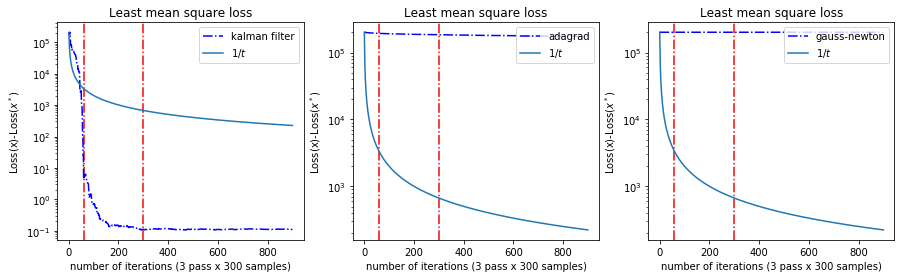

In [15]:
# generation of datas for LMS (with the same parameters than in previous part)
Nsamples=300
d=60
c=2
sigmaLabel=1
sigmaInput=1
Y,U,x_opt,Cov_u=LMS_data_generator(Nsamples,d,c,sigmaLabel,sigmaInput,seed=4,covarianceInputs='ill-conditionned')
Y=Y.reshape(Nsamples,1)

# initial uncertainty:
sigma0=1e3
Cov_x0=np.identity(d)*sigma0**2 #no initial information on parameters

# initial error:
x0=np.random.multivariate_normal(x_opt,Cov_x0) 
x0=x0.reshape(d,1)

P0=Cov_x0

R=sigmaLabel**2 # we suppose the variance of labels is known
numberPass=3
N=Nsamples*numberPass

x_on,P_on,history_x_on,history_P_on = onlineNewton(x0,LA.inv(P0),U,Y,grad_li,hessian_li,numberPass)
x_ka,P_ka,history_x_ka,history_P_ka = linearKalmanFilter(x0,P0,R,U,Y,numberPass)
x_ada,P_ada,history_x_ada,history_P_ada = stochasticGradient(x0,U,Y,grad_li,stepADAGRAD,numberPass,\
                                                         typeOptim='adagrad',sigma0=sigma0)
x_gn,P_gn,history_x_gn,history_P_gn = stochasticGradient(x0,U,Y,grad_li,stepADAGRAD,numberPass,\
                                                         typeOptim='gauss-newton',sigma0=sigma0)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
plotLMSLoss(ax1,U,Y,x_opt,numberPass,[history_x_ka],['kalman filter'],plotOptimal=True)
plotLMSLoss(ax2,U,Y,x_opt,numberPass,[history_x_ada],['adagrad'],plotOptimal=True)
plotLMSLoss(ax3,U,Y,x_opt,numberPass,[history_x_gn],['gauss-newton'],plotOptimal=True)

plt.show()

The Kalman filter is very robust to bad condition number and converge even faster in this case. However we have supposed we have a consistent guess on the initial error $x_0$.

## Evaluation of consistency

To check the consistance of the covariance matrix in high dimension, we compare the root mean square error with the sum of the theoretical standard deviations given by the square root of the trace of the covariance matrix. Finally the bound at $1 \sigma$ of the root mean square errors is : 

\begin{align}
& \sqrt{\frac{1}{d} \sum_{i=1}^d [(\hat{x}_t-x^*)^2]_i} < \sqrt{ \frac{1}{d}\mathrm{Tr} P_t}\\
&
\end{align} 

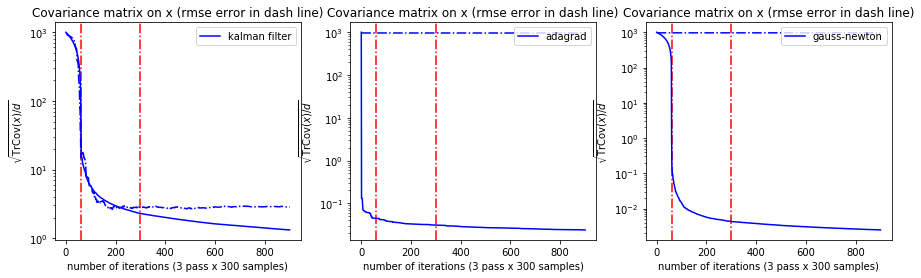

In [16]:
def computeDeviations(history_x,history_P,x_opt):
    N,d=history_x.shape
    rmse=np.sqrt(np.sum((history_x-x_opt.T)**2,axis=1)/d)
    TensorCov=history_P.reshape(N,d,d)
    TraceCov=np.asarray([np.sqrt(np.trace(TensorCov[i])/d) for i in range(0,N)])
    return rmse,TraceCov

def plotRMSE(ax,x_opt,numberPass,list_histo_x,list_histo_P,list_labels,plotRMSE=True,axesLegend=True):
    NIter,d=list_histo_x[0].shape
    #N,d=U.shape
    #NIter=N*numberPass
    N=int(NIter/numberPass)
    t=np.arange(0,NIter)

    ax.axvline(d,color='r',linestyle='-.') 
    ax.axvline(N,color='r',linestyle='-.')


    list_col=['b','g','y','m','c','grey','ivory','olive','brown']

    for idx in range(0,len(list_histo_x)):
        history_x=list_histo_x[idx]
        history_P=list_histo_P[idx]
        label=list_labels[idx]
        col=list_col[idx]
        rmse, sqTrCov=computeDeviations(history_x[t],history_P[t,:],x_opt)
        ax.semilogy(t,sqTrCov,color=col,label=label)
        if plotRMSE:
            ax.semilogy(t,rmse,'-.',color=col)

    if axesLegend:
        ax.set_title('Covariance matrix on x (rmse error in dash line)')
        ax.set_xlabel('number of iterations ({} pass x {} samples)'.format(numberPass,N))
        ax.set_ylabel('$\sqrt{\mathrm{Tr}\mathrm{Cov}(x)/d}$')
        ax.legend(loc='upper right')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
plotRMSE(ax1,x_opt,numberPass,[history_x_ka],[history_P_ka],['kalman filter'])
plotRMSE(ax2,x_opt,numberPass,[history_x_ada],[history_P_ada],['adagrad'])
plotRMSE(ax3,x_opt,numberPass,[history_x_gn],[history_P_gn],['gauss-newton'])

plt.show()

For the Kalman filter: we see the covariance is consistant, ie predict very well the deviation of the estimate, at least for the first pass on datas. Adagrad is over confident and the covariance drop too early. Gauss-Newton covariance do not drop too early but the Gauss-Newton approximation offer poor rate of convergence.

We identify 3 phases in the Kalman learning: 

- The first phase lasts until $t=d$, it is a fondamental phase where the filter estimate the covariance matrix with partial observations. A full rank matrix is only available after at least $d$ observations. The covariance drop strongely at the end of this phase where the prior $P_0$ (of high value if we have no prior information) is totally forgotten.  
- We enter then in the second phase where the filter exploit the estimated Hessian to reach the optimal MSE at $t=N samples$. 
- The third phase $t>N samples$ correspond to additional cycles on datas. Once the optimal is reached their is no more possible improvement and the rse do not decrease in this phase. However this phase can be usefull in the case where the prior is too low (see following figures). 

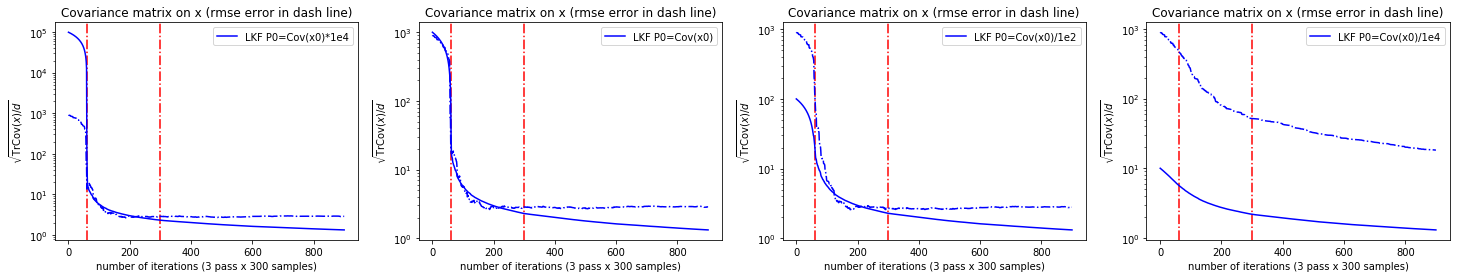

In [17]:
# initial uncertainty:
Cov_x0=np.identity(d)*1e6 #no initial information on parameters
P0_1=Cov_x0*1e4
P0_2=Cov_x0
P0_3=Cov_x0/1e2
P0_4=Cov_x0/1e4

# initial error:
x0=np.random.multivariate_normal(x_opt,Cov_x0) 
x0=x0.reshape(d,1)
    
R=sigmaLabel**2 # we suppose the variance of labels is known
numberPass=3
N=Nsamples*numberPass
x1,P1,history_x1,history_P1 = linearKalmanFilter(x0,P0_1,R,U,Y,numberPass)
x2,P2,history_x2,history_P2 = linearKalmanFilter(x0,P0_2,R,U,Y,numberPass)
x3,P3,history_x3,history_P3 = linearKalmanFilter(x0,P0_3,R,U,Y,numberPass)
x4,P4,history_x4,history_P4 = linearKalmanFilter(x0,P0_4,R,U,Y,numberPass)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(25,4))
plotRMSE(ax1,x_opt,numberPass,[history_x1],[history_P1],['LKF P0=Cov(x0)*1e4'])
plotRMSE(ax2,x_opt,numberPass,[history_x2],[history_P2],['LKF P0=Cov(x0)'])
plotRMSE(ax3,x_opt,numberPass,[history_x3],[history_P3],['LKF P0=Cov(x0)/1e2'])
plotRMSE(ax4,x_opt,numberPass,[history_x4],[history_P4],['LKF P0=Cov(x0)/1e4'])
plt.show()

Overestimate the initial error $||x_0-x^*||$ is preferable to underestimate it. In the case where the initial error is underestimated, additional cycles on data can help convergence. 